# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [2]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [88]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split

#убираем признак salary, чтобы не произошел лик данных
df.drop(columns=['salary'], inplace=True)

In [4]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,USD,120000,CA,100,CA,M


In [5]:
X = df.drop(columns=['salary_in_usd'])
y = df['salary_in_usd']

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 
                        'company_location', 'company_size']

X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
X_valid_encoded = pd.get_dummies(X_valid, columns=categorical_features, drop_first=True)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_valid_encoded = X_valid_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

model = LinearRegression()
model.fit(X_train_encoded, y_train)
y_test_pred = model.predict(X_test_encoded)

mape = mean_absolute_percentage_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)

MAPE:  190870654.48145336
RMSE:  66928931217098.08


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
import time
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=3, scoring='neg_mean_squared_error', 
                           verbose=1, n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train_encoded, y_train)
training_time = time.time() - start_time


best_params = grid_search.best_params_
best_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)

In [123]:
start_time = time.time()
best_model.fit(X_train_encoded, y_train)
training_time = time.time() - start_time
start_time = time.time()
y_pred = best_model.predict(X_valid_encoded)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)
print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

MAPE:  0.33592233721382536
RMSE:  49700.15135990503
Время обучения:  0.9548933506011963
Время предсказания:  0.09335947036743164


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [129]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 50],
    'bagging_temperature': [0.0, 0.5],
    'random_strength': [1, 2, 5],
    'one_hot_max_size': [2, 10],
    'leaf_estimation_iterations': [1, 5],
    'subsample': [0.75, 1.0]
}

model = CatBoostRegressor(logging_level='Silent')
random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                 n_iter=50, cv=3, scoring='neg_mean_squared_error', 
                                 verbose=1, n_jobs=-1, random_state=42)

grid_search.fit(X_train_encoded, y_train)
best_params = random_search.best_params_
best_model = CatBoostRegressor(**best_params, logging_level='Silent')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [131]:
start_time = time.time()
best_model.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred = best_model.predict(X_valid_encoded)
mape = mean_absolute_percentage_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

start_time = time.time()
y_pred = best_model.predict(X_valid_encoded)
prediction_time = time.time() - start_time

print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

MAPE: 0.3403022563979832
RMSE: 49805.690447638015
Время обучения:  10.710519075393677
Время предсказания:  0.021137475967407227


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [142]:
from catboost import Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

model = CatBoostRegressor(cat_features=categorical_features, logging_level='Silent')

random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                   n_iter=50, cv=3, scoring='neg_mean_squared_error', 
                                   verbose=1, n_jobs=-1, random_state=42, error_score='raise')

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = CatBoostRegressor(**best_params, logging_level='Silent')

start_time = time.time()
best_model.fit(train_pool)
training_time = time.time() - start_time

y_pred = best_model.predict(valid_pool)

mape = mean_absolute_percentage_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f'MAPE: {mape}')
print(f'RMSE: {rmse}')

start_time = time.time()
y_pred = best_model.predict(valid_pool)
prediction_time = time.time() - start_time

print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
MAPE: 0.35569628969667394
RMSE: 49806.73946627879
Время обучения:  29.045947313308716
Время предсказания:  0.0029969215393066406


**Ответ:** Качество осталось таким же, при этом время очень сильно увеличилось, лучше кодировать признаки отдельно

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [146]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 660.6 kB/s eta 0:00:02
   - -------------------------------------- 0.1/1.3 MB 656.4 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.3 MB 1.0 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.3 MB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 1.8 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.3 MB 1.8 MB/s eta 0:00:01
   --------------- ------------------------ 0.5/1.3 MB 1.6 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 1.9 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 1.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.1/1.3 MB 2.4 MB/s eta 0:00:01
   -------------------------------- ------- 1.1/1.3 MB 2.4 MB/s eta 0:00:01
   ------------------------------------- -- 1.3/1.3 MB 2.4 MB/s eta 0:00:01
   ------------

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import time

params = {
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.3],
    'n_estimators': [100, 200, 500],
    'num_leaves': [20, 50, 100],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
}

lgbm = LGBMRegressor(random_state=42)

grid_search = GridSearchCV(estimator=lgbm, param_grid=params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

best_params = grid_search.best_params_
print('Лучшие параметры: ', best_params)

best_lgbm = LGBMRegressor(**best_params, random_state=42)
best_lgbm.fit(X_train_encoded, y_train)

start_time = time.time()
y_pred = best_lgbm.predict(X_valid_encoded)
prediction_time = time.time() - start_time

In [14]:
mape = mean_absolute_percentage_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)

print('Время обучения: ', training_time)
print('Время предсказания: ', prediction_time)

MAPE:  0.3197231192301748
RMSE:  49918.52166595032
Время обучения:  278.23482298851013
Время предсказания:  0.00853419303894043


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** # 
Хуже всего работает линейная модель, она обучается быстро, но результаты по качеству дает ужасные. 
XGboost обучается чуть дольше, но не критично долго. Дает намного лучшие результаты по качеству, чем линейная модель. 
CatBoost, в отличие от XGboost обучается куда дольше, а время предсказания имеет почти такое же. При этом качетсво модели имеет почти такие же показатели, как и XGboost. LightGBM обучается дольше всех, при этом время предсказания занимает меньше времени. Показатели качества схожи с предыдущими 2-мя моделями. Можно сказать, что в данном случае лучше всего работает CatBoost.

Также у данных моделей разные гиперпараметры. У каждой из моделей есть базовые гиперпараметры такие как количество деревьев, learning rate (контролирует вклад каждого из деревьев) и глубина деревьев. В XGboost есть гиперпараметр gamma (минимальное уменьшение потерь, необходимое для разделения узла), в CatBoost встроена работа с категориальными признаками, в LightGBM есть гиперпараметры для бэггинга (доля и частота).

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [47]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [48]:
ratings = ratings.transpose()
ratings.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [49]:
ratings = ratings.drop('user')
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [50]:
ratings = ratings.fillna(0)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
"ross, rick",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [51]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings)
labels = kmeans.labels_

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [52]:
unique, count = np.unique(labels, return_counts=True)
for i in range(len(unique)):
    print(f'{unique[i]}: {count[i]}')

0: 115
1: 1
2: 1
3: 882
4: 1


**Ответ:** Кластеризация получилась неполезной, поскольку она содержит кластеры состоящие из 1 объекта, которые вероятнее всего просто являются выбросами.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [53]:
df = ratings.copy()
df['label'] = labels
df = df[df['label'].isin([1, 4])]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,label
the beatles,0.0,0.0,0.0,0.0,0.043529,0.0,0.0,0.0,0.093398,0.017621,...,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.0,4
日dir en grey,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [54]:
print(df.iloc[0].mean())
print(ratings.mean().mean())

print(df.iloc[0].mean() / ratings.mean().mean())

0.01916514356333879
0.0009932000000000003
19.29635880320055


**Ответ:** Битлс слушают в 20 раз чаще чем других исполнителей в среднем, поэтому в данной выборке эта группа отделилась в отдельный кластер, т.к. это выброс.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [58]:
inds = ratings.index

In [ ]:
from sklearn.preprocessing import normalize

ratings = pd.DataFrame(normalize(ratings))
ratings['inds'] = inds

In [64]:
ratings.set_index('inds', inplace=True)
ratings

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
inds,,,,,,,,,,,,,,,,,,,,,
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [65]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(ratings)
labels = kmeans.labels_
unique, count = np.unique(labels, return_counts=True)
for i in range(len(unique)):
    print(f'{unique[i]}: {count[i]}')

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


0: 79
1: 162
2: 133
3: 140
4: 486


**Ответ** После нормализации кластеризация стала лучше, поскольку уже можно говорить о балансе классов, нет классов где очень мало объектов

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [76]:
from scipy.spatial.distance import cosine

centroids = kmeans.cluster_centers_

cosine_distance = np.zeros((len(centroids), len(ratings)))
for i, centroid in enumerate(centroids):
    for j, artist_vector in enumerate(ratings.values):
        cosine_distance[i, j] = cosine(centroid, artist_vector)

artists = []
for i in range(len(centroids)):
    artists.append(ratings.index[index] for index in np.argsort(cosine_distance[i])[:10])

for i, top_artists in enumerate(artists):
    print(f"Кластер {i}:")
    print('; '.join(top_artists))

Кластер 0:
nas; jay-z; kanye west; lupe the gorilla; a tribe called quest; the roots featuring d'angelo; gangstarr; little brother; lil' wayne; murs and 9th wonder
Кластер 1:
fall out boy; the all-americian rejects; paramore; kelly clarkson; john mayer; the fray; maroon5; dashboard confesssional; somethings corporate; coldplay
Кластер 2:
brand new; blink-182; alkaline trio; against me!; underoath; descendents; new found glory; less than jake; thrice; chiodos
Кластер 3:
the beatles; the rolling stones; dylan. bob; who; led zeppelin.; miles davis.; simon and garfunkel; young, neil; pink fluid; velvet underground
Кластер 4:
radiohead; the arcade fire; the shins; sufjan stevens; belle and sebastian; broken social scene; the pixies; animal collective; modest mouse; spoon


**Ответ:** # Можно заметить, что кластеры разделены по жанрам, то есть в каждом из кластеров представлены самые популярные исполнители того или иного жанра. (0 - реп, 1 - альтернатива, 2 - панк, 3 - рок, 4 - инди)

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

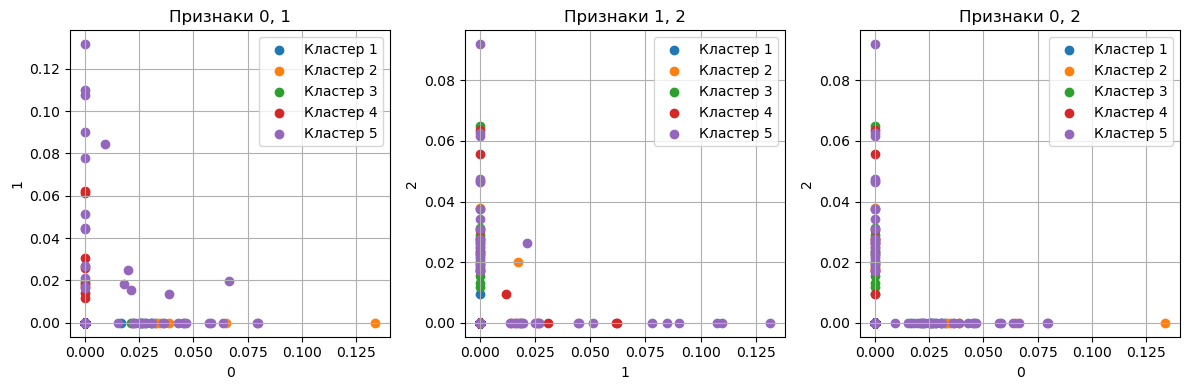

In [83]:
import matplotlib.pyplot as plt

feature_pairs = [(0, 1), (1, 2), (0, 2)]
plt.figure(figsize=(12, 4))

for i, (feature1_index, feature2_index) in enumerate(feature_pairs, 1):
    plt.subplot(1, 3, i)
    for label in range(len(np.unique(labels))):
        plt.scatter(ratings.loc[labels == label, feature1_index], ratings.loc[labels == label, feature2_index], label=f'Кластер {label+1}')
    plt.xlabel(ratings.columns[feature1_index])
    plt.ylabel(ratings.columns[feature2_index])
    plt.title(f'Признаки {ratings.columns[feature1_index]}, {ratings.columns[feature2_index]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**Ответ:** Данная визуализация абсолютно ничего не показывает, поскольку мы просто смотрим зависимость по 2 случайным слушателям, а нам бы хотелось визуализировать всех. Кластеры на данных графиках не прослеживаются.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

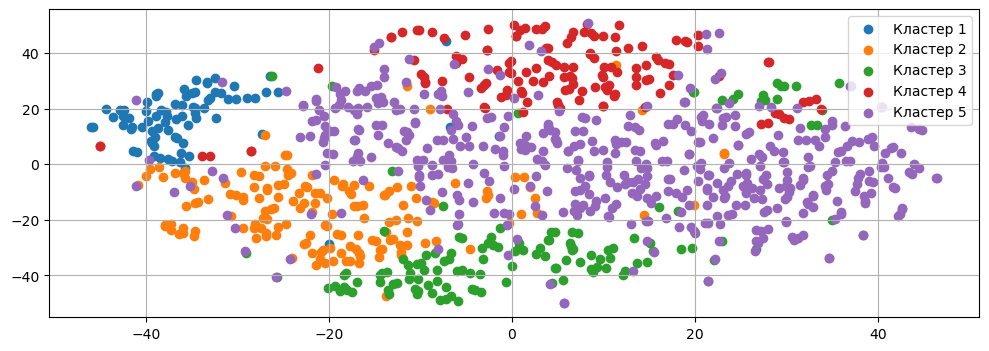

In [86]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
data = tsne.fit_transform(ratings)

plt.figure(figsize=(12, 4))
for label in range(len(np.unique(labels))):
    plt.scatter(data[labels == label, 0], tsne_data[labels == label, 1], label=f'Кластер {label+1}')
    
plt.legend()
plt.grid(True)
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [90]:
from sklearn.metrics import silhouette_score
scores = []
for n_clusters in range(2, 101):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(ratings)
    labels = kmeans.labels_
    score = silhouette_score(ratings, labels)
    scores.append(score)

In [93]:
ans = scores.index(max(scores)) + 2
ans

84

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [96]:
kmeans = KMeans(84, random_state=42)
kmeans.fit(ratings)
labels = kmeans.labels_

In [97]:
centroids = kmeans.cluster_centers_
cosine_distance = np.zeros((len(centroids), len(ratings)))

for i, centroid in enumerate(centroids):
    for j, artist_vector in enumerate(ratings.values):
        cosine_distance[i, j] = cosine(centroid, artist_vector)

artists = []
for i in range(len(centroids)):
    artists.append(ratings.index[index] for index in np.argsort(cosine_distance[i])[:10])

for i, top_artists in enumerate(artists):
    print(f"Кластер {i}:")
    print('; '.join(top_artists))

Кластер 0:
raekwon; wu-tang clan; gza/genius; ghostface killah; mobb deep; cypress hill; nas; gangstarr; jay-z; a tribe called quest
Кластер 1:
she wants revenge; shiny toy guns; the bravery; pink*; mika; three days grase; placebo; frou frou; digitalism; the dandy warhols
Кластер 2:
vampire weekend; mgmt; girl talk; the go! team; the blow; dr. dog; bishop allen; the dodos; of montreal; the shins
Кластер 3:
the flaming lips; the apples in stereo; elvis costello and the attractions; grandaddy; the notwist; sparklehorse; orbital; elvis costello; sigur rós; m. ward
Кластер 4:
the smashing pumpkins; vnv nation; the blood brothers; moby; the pillows; niИ; system of a down; rammstein; radiohead; air
Кластер 5:
all time low; mayday parade; forever the sickest kids; fall out boy; cute is what we aim for; the academy is...; cobra starship; paramore; the spill canvas; boys like girls
Кластер 6:
kanye west; jay-z; lupe the gorilla; lil' wayne; t.i.; ludacris; t-pain; drake; chris brown; nas
Класте

**Ответ:** Смысл кластеров остался прежним, они делятся по жанрам, но теперь более точно. Кластер 11:
the used; afi; my chemicall romance; him; |avenged sevenfold; from first to last; atreyu; bullet for my valintine; 30 seconds to mars; fall out boy - только панк-рок музыканты. Кластер 50:
Вольфганг Амадей Моцарт; ВИВАЛЬДИ; Бах Иоганн Себастьян; ШОПЕН; ルートヴィヒ・ヴァン・ベートーヴェン; john williams (g); billy joel; sam cooke; Йrik satie; lord of the rings - классическая музыка.

Сделайте t-SNE визуализацию полученной кластеризации.

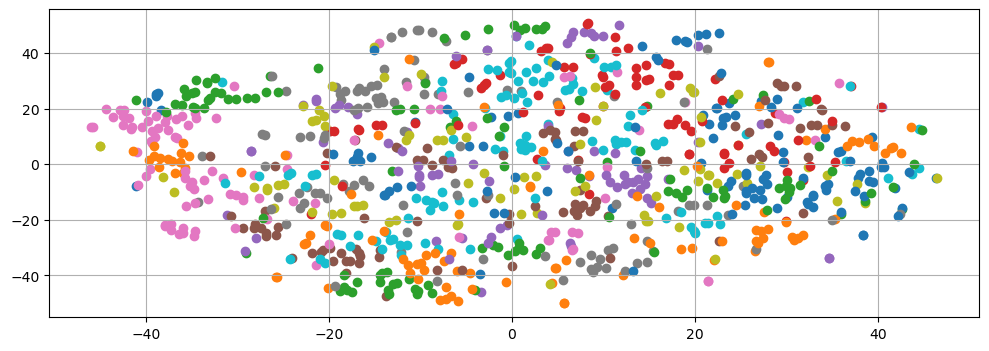

In [100]:
tsne = TSNE(n_components=2, random_state=42)
data = tsne.fit_transform(ratings)

plt.figure(figsize=(12, 4))
for label in range(len(np.unique(labels))):
    plt.scatter(data[labels == label, 0], tsne_data[labels == label, 1])
    
plt.grid(True)
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

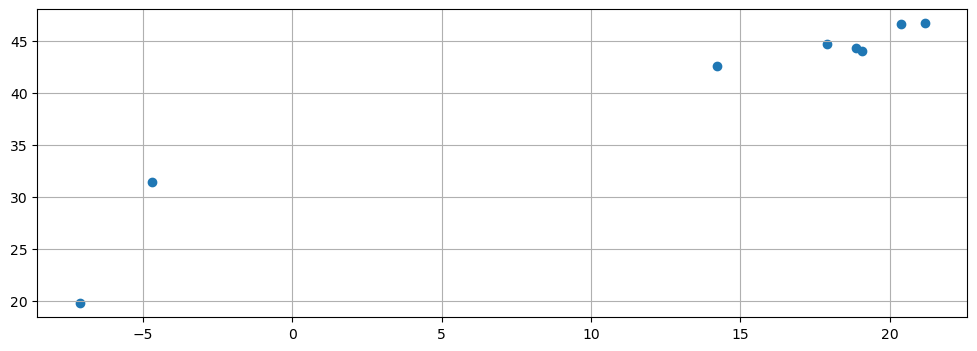

In [105]:
plt.figure(figsize=(12, 4))
plt.scatter(data[labels == 50, 0], data[labels == 50, 1])
plt.grid(True)
plt.show()

**Ответ:** Кластер плохо отображается в визуализации, конечно есть группа точек, но при есть и точки которые находятся слишком далеко друг от друга.